# Convergence

<p align=justify>
When using numerical tools, we must not forget that there will always be an inherent error to the obtained solution. Floating point number solutions are limitted by how many discretization levels our machine can handle. On the other hand, the error also depends on how many different, smaller problems our problem can be divided into. <b>This means that the accuracy of our solution depends on the resolution of our problem space.</b>
</p>


<p align=justify>
More resolution means a better solution accuracy, but it also means more computer data to process, increasing the computational (time and memory) cost of the solution. Therefore, we must find a balance between accuracy and computational cost. 

## Measuring the Error

<p align= justify>
There are two main methods to determine if our solution has converged:
</p>

- Predict the a posteriori error <b>Estimate</b> of the computed solution (useful for defining adaptive mesh refinement strategies)
- Perform a <b>Convergence Test</b> to find out the convergence order of our solution, and then use this order to extrapolate the obtained results to an infinite resolution.


### Convergence Test
<p align=justify>
The convergence test is a simpler method, and it is the approach that will be used for now to help us determine the amount of error of our computed solution.</p>

<p>
Convergence Tests are done by increasing the resolution uniformingly, which allows to determine the order of convergence of our solution. The higher the order, the lower the error. Simple.
</p>

<b> Note: We only need the required resolution to achieve the desired accuracy. </b>

### The Accuracy - Resolution Tradeoff
<p align=justify>
By setting a minimum value for the absolute error, we can increase the resolution of our problem space to the absolute necessary minimum order of convergence to achieve the desired accuracy. This is the best way to balance accuracy and computational cost.
</p>

## Electrostatics Example

<p align=justify>
To demonstrate the convergence test, we will solve a simple electrostatics problem: <br/>  - Calculate the electrostatic potential on the symmetry axis of a uniformly charged square. These results will be used to demostrate how the convergence test enables us to extrapolate the results to a infinitely fine cell size resolution of the problem space.</p>

### Electrostatics 101

<p align=justify>A simple special case of Maxwell's equations is the electrostatics problem. In this case, the electric field doesn't vary with time. This implies that the Farady Law (Eq. 2) is given by:</p>

$$\nabla \times \vec{E} = 0$$

And thus:

$$\vec{E} = -\nabla \phi$$

where $\phi$ is the electrostatic potential.

<p align=justify>
Poissons equation then becomes:
</p>

$$\nabla \cdot (\epsilon \nabla \phi) = -\rho$$

<p align=justify>
In free space the "solution" to this equation in 3D can be given by:
</p>

$$\phi(r) = \int \frac{\rho(\vec{r'})}{4 \pi \epsilon_0 ||\vec{r} - \vec{r'}||} dV'$$

<p align=justify>This integral formulation of this electrostatics problem will be further explored in Chapter 7, in Capacitance Extraction examples.</p>


<p align=ajustify>
Integral formulations of Maxwell's Equations can sometimes be quite useful to simplify our life when trying to solve a problem. There are three main field integral equations:
</p>

- Electric Field Integral Equation (EFIE)
- Magnetic Field Integral Equation (MFIE)
- Combined Field Integral Equation (CFIE)


<p align=justify>
For a conducting square plate sheet defined in:
</p>

$$ -a \leq x \leq a $$
$$ -a \leq y \leq a $$

<p align=justify>
and while exploiting the symmetry of the geometry, the electrostatic potential can be calculated by solving the following integral:
</p>

$$\phi(0,0,z) = \frac{\rho_{S0}}{4 \pi \epsilon_0} \int_{x=-a}^{a} \int_{y=-a}^{a} \frac{1}{\sqrt{x'^2 + y'^2 + z^2}} dx' dy' = $$ 
$$\frac{\rho_{S0}}{4 \pi \epsilon_0} \int_{x=-a}^{a} dx' \int_{y=-a}^{a} \frac{1}{\sqrt{x'^2 + y'^2 + z^2}} dy' = $$ 
$$\frac{\rho_{S0}}{\pi \epsilon_0} \int_{x=0}^{a} dx' \int_{y=0}^{a} \frac{1}{\sqrt{x'^2 + y'^2 + z^2}} dy' = \frac{\rho_{S0}}{\pi \epsilon_0} I (z, a)$$

<p align=justify>
Now all we have to do is compute I(z,a) and we are done. This can be done by using numerical integration rules such as:
</p>

- Midpoint Integration Rule:

$$ \int_{x}^{x+h} f(x) dx \approx h f \left(x + \frac{h}{2} \right) $$

- Simpson's Rule:

$$ \int_{x}^{x+h} f(x) dx \approx \frac{h}{6} \left[ f(x) + 4 f\left( h + \frac{h}{2} \right) + f(x+h) \right] $$


In [2]:
from enum import Enum

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import numpy as np
import gdstk as gtk

%matplotlib inline

In [3]:
"""
Compute potential on symmetry axis of square plate.
"""
class IntRule(Enum):
    MIDPOINT = 'midpoint'
    SIMPSON = 'simpson'

def potential(z:float, a:float, n: int, rule:str='midpoint', plot_mesh:bool=True):
    """Compute the potential on the symmetry axis of a square plate,
    defined by the geometric boundaries:
        0<x<a, 0<y<a, z=0.
    The surfce charge density is constant, and given by:
        \rho_surface (x,y) = \rho_surface0
    We are seeking the potential at two points on the
    symmetry axis:
        (x, y, z) = (0, 0, a)
        (x, y, z) = (0, 0, 0) (center of the square)
    Args:
        z (float): the height over the plate of the test point charge
        a (float): Size of each side of the square plate.
        n (int): Number of squares to discretize each dimension of the plate.
        rule (str): The integration rule to use
    """
    x = np.linspace(0, a, n)
    y = np.linspace(0, a, n)
    xx, yy = np.meshgrid(x, y)
    if plot_mesh:
        plt.plot(xx, yy, marker='o', color='k', linestyle='none')
    h = a / n # the spatial step size in each dimension
    zs = z**2
    xs = np.zeros_like(x)
    ys = np.zeros_like(y)
    integ = 0.0
    if rule == IntRule.MIDPOINT.value:
        # Midpoint integration
        xs = ( x + h/2 )**2
        ys = ( y + h/2 )**2
        xxs, yys = np.meshgrid(xs, ys)
        integ = np.sum( np.sum(1 / np.sqrt( xxs + yys + zs )) ) 
    elif rule == IntRule.SIMPSON.value:
        # Simpson's rule
        for i in range(n):
            x1 = x[i]**2
            x2 = ( x[i] + h/2 )**2
            x3 = ( x[i] + h )**2
            y1 = y**2
            y2 = ( y + h/2 )**2
            y3 = ( y + h )**2
            integ += np.sum(
                1/np.sqrt(x1+y1+zs) + 1/np.sqrt(x1+y3+zs) + \
                1/np.sqrt(x3+y1+zs) + 1/np.sqrt(x3+y3+zs) + \
                4/np.sqrt(x2+y1+zs) + 4/np.sqrt(x2+y3+zs) + \
                4/np.sqrt(x1+y2+zs) + 4/np.sqrt(x3+y2+zs) + \
                16/np.sqrt(x2+y2+zs)
            ) / 36
    else:
        raise ValueError("Invalid integration rule: {}".format(rule))
    return integ * h**2


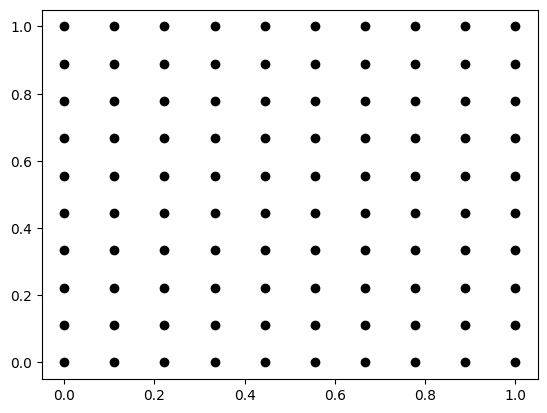

In [4]:
a = z = 1.0
nn = [2**i for i in range(2, 12)]
rules = [IntRule.MIDPOINT.value, IntRule.SIMPSON.value]
pot = potential(z, a, 10, rule=rules[0], plot_mesh=True)
pots = np.zeros((len(rules), len(nn)))
for i,rule in enumerate(rules):
    for k,n in enumerate(nn):
        pots[i, k] = potential(z, a, n, rule=rule, plot_mesh=False)


In [5]:
# Plot table of results
from prettytable import PrettyTable
tab = PrettyTable(["n", "h [m]", "Imid(1,1) [m]", "Isimp(1,1) [m]"])
for row in zip(nn, a/np.array(nn), pots[0,:], pots[1,:]):
    tab.add_row(row)
print(tab)

+------+---------------+--------------------+--------------------+
|  n   |     h [m]     |   Imid(1,1) [m]    |   Isimp(1,1) [m]   |
+------+---------------+--------------------+--------------------+
|  4   |      0.25     | 0.7272663501875852 | 0.7262444447350174 |
|  8   |     0.125     |  0.75990545363187  | 0.7595988488751104 |
|  16  |     0.0625    | 0.7765562346873228 | 0.776471488420548  |
|  32  |    0.03125    | 0.7849421488052701 | 0.7849198446141313 |
|  64  |    0.015625   | 0.789147215418029  | 0.7891414930462693 |
| 128  |   0.0078125   | 0.7912523732026471 | 0.7912509239052836 |
| 256  |   0.00390625  | 0.7923055560650103 | 0.7923051913767519 |
| 512  |  0.001953125  | 0.7928322918529528 | 0.7928322003837817 |
| 1024 |  0.0009765625 | 0.7930956949991715 | 0.7930956720946395 |
| 2048 | 0.00048828125 | 0.7932274052802523 | 0.7932273995494591 |
+------+---------------+--------------------+--------------------+


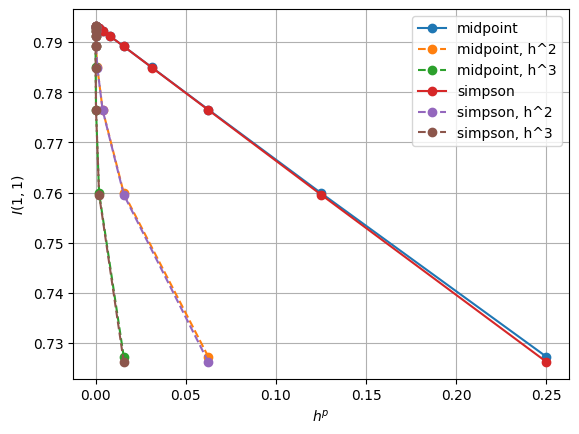

In [6]:
# When h is sufficiently small, the midpoint rule is more accurate
# Plot the values of the integral as a function of h**2
plt.figure()
plt.plot((a/np.array(nn)), pots[0,:], marker='o', label='midpoint', linestyle='-')
plt.plot((a/np.array(nn))**2, pots[0,:], marker='o', label='midpoint, h^2', linestyle='--')
plt.plot((a/np.array(nn))**3, pots[0,:], marker='o', label='midpoint, h^3', linestyle='--')
plt.plot((a/np.array(nn)), pots[1,:], marker='o', label='simpson', linestyle='-')
plt.plot((a/np.array(nn))**2, pots[1,:], marker='o', label='simpson, h^2', linestyle='--')
plt.plot((a/np.array(nn))**3, pots[1,:], marker='o', label='simpson, h^3', linestyle='--')
plt.legend()
plt.grid()
plt.xlabel(r'$h^p$')
plt.ylabel(r'$I(1,1)$')
plt.show()

In [7]:
# extrapolate the computed results 
# using polyfit, to find I in order of h**2
orders = range(1, 6)
pfit_midpoint = []
pfit_simpson = []
for order in orders:
    pfit_midpoint.append(np.polyfit((a/np.array(nn))**2, pots[0,:], order))
    pfit_simpson.append(np.polyfit((a/np.array(nn))**2, pots[1,:], order))
# plot the extrapolated values
pfit_midpoint

[array([-1.04247511,  0.78874036]),
 array([23.29951233, -2.47373055,  0.79095934]),
 array([-2.74404614e+03,  2.36024879e+02, -5.06842034e+00,  7.92002868e-01]),
 array([ 1.34057798e+06, -1.12502676e+05,  1.93849534e+03, -1.00267241e+01,
         7.92566101e-01]),
 array([-2.60945597e+09,  2.17858487e+08, -3.65911306e+06,  1.50547690e+04,
        -1.95316871e+01,  7.92883432e-01])]

In [8]:
import sympy as sp

h = sp.Symbol('h')
Ih = sp.Symbol('I(h)')
sp.init_printing()
print("Midpoint rule")
poly = pfit_midpoint[1]
Imid = sp.Poly(poly,h)
sp.Eq(Ih, Imid.as_expr())

Midpoint rule


In [9]:
print("Simpson's rule")
poly = pfit_simpson[1]
Isimp = sp.Poly(poly,h)
sp.Eq(Ih, Isimp.as_expr())

Simpson's rule


In [10]:
# Estimating convergence order 
# using the extrapolated values
hh = a/np.array(nn)
conv_order_mid = np.zeros_like(hh)
conv_order_simp = np.zeros_like(hh)
# compute the convergence order
# for the midpoint and simpson rules
# for a polynomial order of 1
for i, hi in enumerate(hh[0:-2]):
    Ihi = float(Imid.subs(h, hi))
    Ihip1 =  float(Imid.subs(h, hh[i+1]))
    Ihip2 = float(Imid.subs(h, hh[i+2]))
    conv_order_mid[i] = np.log( (Ihi - Ihip1)/(Ihip1 - Ihip2) ) / np.log( hi / hh[i+1] )
    Ihi = float(Isimp.subs(h, hi))
    Ihip1 =  float(Isimp.subs(h, hh[i+1]))
    Ihip2 = float(Isimp.subs(h, hh[i+2]))
    conv_order_simp[i] = np.log( (Ihi - Ihip1)/(Ihip1 - Ihip2) ) / np.log( hi / hh[i+1] )


/var/folders/vv/xctyh4bd2td6k2w_gvh_t2vr0000gn/T/ipykernel_69912/1611750487.py:13: RuntimeWarning: invalid value encountered in log
  conv_order_mid[i] = np.log( (Ihi - Ihip1)/(Ihip1 - Ihip2) ) / np.log( hi / hh[i+1] )
/var/folders/vv/xctyh4bd2td6k2w_gvh_t2vr0000gn/T/ipykernel_69912/1611750487.py:17: RuntimeWarning: invalid value encountered in log
  conv_order_simp[i] = np.log( (Ihi - Ihip1)/(Ihip1 - Ihip2) ) / np.log( hi / hh[i+1] )


In [11]:
# print the table of convergence orders
tab = PrettyTable(["h [m]", "conv. order mid", "conv. order simp"])
for row in zip(hh[0:-1], conv_order_mid, conv_order_simp):
    tab.add_row(row)
print(tab)

+--------------+---------------------+--------------------+
|    h [m]     |   conv. order mid   |  conv. order simp  |
+--------------+---------------------+--------------------+
|     0.25     |  2.724845946826918  | 2.731889531456529  |
|    0.125     |         nan         |        nan         |
|    0.0625    | -1.2551612559947223 | -1.204517565569154 |
|   0.03125    |  0.5194625852087026 | 0.523336909212157  |
|   0.015625   |  0.8088862679476824 | 0.8101045432217433 |
|  0.0078125   |  0.9131681856921203 | 0.9136708806511873 |
|  0.00390625  |  0.958468385718001  | 0.9586983940542388 |
| 0.001953125  |  0.9796741022185582 | 0.9797842926340452 |
| 0.0009765625 |         0.0         |        0.0         |
+--------------+---------------------+--------------------+


## The power of Python and Numpy

The true power of Python relies in its vast ecosystem of libraries and user-developed additional content. Numpy is a powerful library that allows us to perform numerical operations in a very efficient way. It is also the basis for other libraries such as Scipy, which contains a lot of useful numerical methods and algorithms. Being written in C/C++, it is also very fast, and whenever it is possible, try to use Numpy functions instead of writing your own. This will make your code much faster.

In [12]:
# using scipy's simpson integration function
def potential_scipy(z:float, a:float, n: int, rule:str='midpoint', plot_mesh:bool=True):
    """ Compute the potential on the symmetry axis of a square plate,
    defined by the geometric boundaries:
        0<x<a, 0<y<a, z=0.
    The surfce charge density is constant, and given by:
        \rho_surface (x,y) = \rho_surface0
    We are seeking the potential at two points on the
    symmetry axis:
        (x, y, z) = (0, 0, a)
        (x, y, z) = (0, 0, 0) (center of the square)
    Args:
        z (float): the height over the plate of the test point charge
        a (float): Size of each side of the square plate.
        n (int): Number of squares to discretize each dimension of the plate.
        rule (str): The integration rule to use
    """
    from scipy.integrate import trapezoid, simpson
    
    x = np.linspace(0, a, n)
    y = np.linspace(0, a, n)
    xx, yy = np.meshgrid(x, y)
    if plot_mesh:
        plt.plot(xx, yy, marker='o', color='k', linestyle='none')
    h = a / n # the spatial step size in each dimension
    zs = z**2
    xs = np.zeros_like(x)
    ys = np.zeros_like(y)
    integ = 0.0
    if rule == IntRule.MIDPOINT.value:
        # Midpoint integration
        xs = x ** 2
        ys = y ** 2
        f = 1/ np.sqrt( xs + ys + zs )
        f = lambda xsqr: 1/ np.sqrt( xsqr + ys + zs )
        integ = np.array([trapezoid(f(xsqr), x=y) for xsqr in xs])
        integ = trapezoid(integ, x=x)
    elif rule == IntRule.SIMPSON.value:
        # Simpson's rule
        xs = x ** 2
        ys = y ** 2
        f = lambda xsqr: 1/ np.sqrt( xsqr + ys + zs )
        integ = np.array([simpson(f(xsqr), x=y) for xsqr in xs])
        integ = simpson(integ, x=x)
    else:
        raise ValueError("Invalid integration rule: {}".format(rule))
    return integ

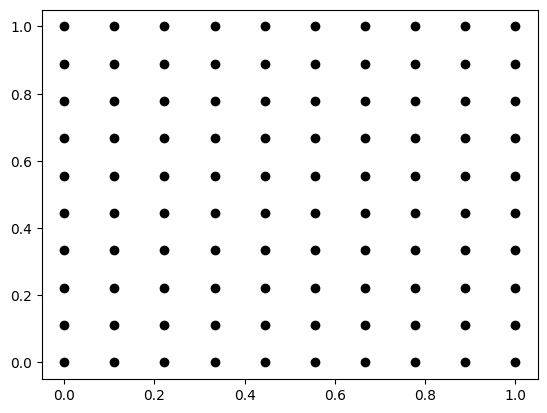

In [13]:
a = z = 1.0
nn = [2**i for i in range(2, 12)]
rules = [IntRule.MIDPOINT.value, IntRule.SIMPSON.value]
pot = potential_scipy(z, a, 10, rule=rules[0], plot_mesh=True)
pots = np.zeros((len(rules), len(nn)))
for i,rule in enumerate(rules):
    for k,n in enumerate(nn):
        pots[i, k] = potential_scipy(z, a, n, rule=rule, plot_mesh=False)

In [14]:
# Plot table of results
from prettytable import PrettyTable
tab = PrettyTable(["n", "h [m]", "Imid(1,1) [m]", "Isimp(1,1) [m]"])
for row in zip(nn, a/np.array(nn), pots[0,:], pots[1,:]):
    tab.add_row(row)
print(tab)

+------+---------------+--------------------+--------------------+
|  n   |     h [m]     |   Imid(1,1) [m]    |   Isimp(1,1) [m]   |
+------+---------------+--------------------+--------------------+
|  4   |      0.25     |  0.78802025125271  | 0.7914657340133542 |
|  8   |     0.125     | 0.7923774579846878 | 0.7932086478070272 |
|  16  |     0.0625    | 0.7931452984760258 | 0.7933439000852991 |
|  32  |    0.03125    | 0.7933090568459016 | 0.7933574039498661 |
|  64  |    0.015625   | 0.7933469992837549 | 0.7933589172057169 |
| 128  |   0.0078125   | 0.7933561383462161 | 0.7933590964412619 |
| 256  |   0.00390625  | 0.7933583814185714 | 0.7933591182543375 |
| 512  |  0.001953125  | 0.7933589370727796 | 0.7933591209448729 |
| 1024 |  0.0009765625 | 0.7933590753530934 | 0.7933591212789599 |
| 2048 | 0.00048828125 | 0.7933591098443884 | 0.7933591213205822 |
+------+---------------+--------------------+--------------------+


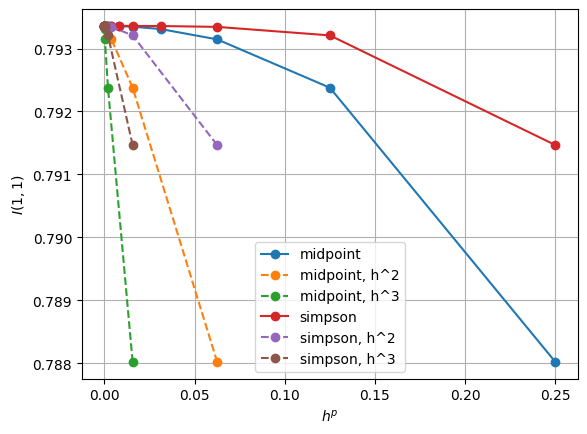

In [15]:
# When h is sufficiently small, the midpoint rule is more accurate
# Plot the values of the integral as a function of h**2
plt.figure()
plt.plot((a/np.array(nn)), pots[0,:], marker='o', label='midpoint', linestyle='-')
plt.plot((a/np.array(nn))**2, pots[0,:], marker='o', label='midpoint, h^2', linestyle='--')
plt.plot((a/np.array(nn))**3, pots[0,:], marker='o', label='midpoint, h^3', linestyle='--')
plt.plot((a/np.array(nn)), pots[1,:], marker='o', label='simpson', linestyle='-')
plt.plot((a/np.array(nn))**2, pots[1,:], marker='o', label='simpson, h^2', linestyle='--')
plt.plot((a/np.array(nn))**3, pots[1,:], marker='o', label='simpson, h^3', linestyle='--')
plt.legend()
plt.grid()
plt.xlabel(r'$h^p$')
plt.ylabel(r'$I(1,1)$')
plt.show()

Using scipy's integration methods, we can easily observe that the integral $I(z,a)$ has a linear realtionship with $h^3$, meaning that when approximating the integral by a polynomial $I(h)$, the term introducing the highest error to the approximation is the h^3 term. This means that the error of the approximation is proportional to $h^3$ and the order of convergence of the algorithm used to compute the potential is 3.

In [16]:
# extrapolate the computed results 
# using polyfit, to find I in order of h**2
orders = range(1, 6)
pfit_midpoint = []
pfit_simpson = []
for order in orders:
    pfit_midpoint.append(np.polyfit((a/np.array(nn))**2, pots[0,:], order))
    pfit_simpson.append(np.polyfit((a/np.array(nn))**2, pots[1,:], order))
# plot the extrapolated values
pfit_midpoint

[array([-0.08493145,  0.79340683]),
 array([-0.4839363 , -0.05520394,  0.79336074]),
 array([ 3.61987475, -0.76455811, -0.05178109,  0.79335937]),
 array([-4.98430486e+02,  4.44284274e+01, -1.39754119e+00, -4.99375838e-02,
         7.93359157e-01]),
 array([ 2.49056568e+05, -2.11637370e+04,  3.82930637e+02, -2.64940906e+00,
        -4.90303934e-02,  7.93359127e-01])]

Midpoint rule


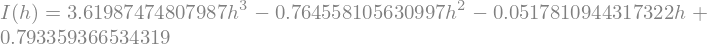

In [17]:
h = sp.Symbol('h')
Ih = sp.Symbol('I(h)')
sp.init_printing()
print("Midpoint rule")
poly = pfit_midpoint[2]
Imid = sp.Poly(poly,h)
sp.Eq(Ih, Imid.as_expr())

Simpson's rule


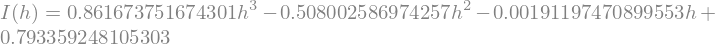

In [18]:
print("Simpson's rule")
poly = pfit_simpson[2]
Isimp = sp.Poly(poly,h)
sp.Eq(Ih, Isimp.as_expr())

In [25]:
# Estimating convergence order 
# using the extrapolated values
hh = a/np.array(nn)
conv_order_mid = np.zeros_like(hh)
conv_order_simp = np.zeros_like(hh)
# compute the convergence order
# for the midpoint and simpson rules
# for a polynomial order of 3
for i, hi in enumerate(hh[0:-2]):
    Ihi = float(Imid.subs(h, hi))
    Ihip1 =  float(Imid.subs(h, hh[i+1]))
    Ihip2 = float(Imid.subs(h, hh[i+2]))
    conv_order_mid[i] = np.log( (Ihi - Ihip1)/(Ihip1 - Ihip2) ) / np.log( hi / hh[i+1] )
    Ihi = float(Isimp.subs(h, hi))
    Ihip1 =  float(Isimp.subs(h, hh[i+1]))
    Ihip2 = float(Isimp.subs(h, hh[i+2]))
    conv_order_simp[i] = np.log( (Ihi - Ihip1)/(Ihip1 - Ihip2) ) / np.log( hi / hh[i+1] )


/var/folders/vv/xctyh4bd2td6k2w_gvh_t2vr0000gn/T/ipykernel_69912/1170332764.py:13: RuntimeWarning: invalid value encountered in log
  conv_order_mid[i] = np.log( (Ihi - Ihip1)/(Ihip1 - Ihip2) ) / np.log( hi / hh[i+1] )


In [26]:
# print the table of convergence orders
tab = PrettyTable(["h [m]", "conv. order mid", "conv. order simp"])
for row in zip(hh[0:-1], conv_order_mid, conv_order_simp):
    tab.add_row(row)
print(tab)

+--------------+--------------------+--------------------+
|    h [m]     |  conv. order mid   |  conv. order simp  |
+--------------+--------------------+--------------------+
|     0.25     |        nan         | 1.4155169824362104 |
|    0.125     | 0.9621160011115147 | 1.7538485263463883 |
|    0.0625    | 1.2776212550327368 | 1.847773914212538  |
|   0.03125    | 1.256826350249704  | 1.8504832235849915 |
|   0.015625   | 1.1753429598825318 | 1.7910602938121047 |
|  0.0078125   | 1.1037996273288433 | 1.675887961822139  |
|  0.00390625  | 1.0567773937581477 | 1.519397013736562  |
| 0.001953125  | 1.029743464134799  | 1.3546653273324627 |
| 0.0009765625 |        0.0         |        0.0         |
+--------------+--------------------+--------------------+
